**Task:** With the classification_data, build an algorithm to predict the binary label. Build a pipeline going from exploratory analysis to model performance evaluation adding comments to each stage.

In [284]:
## import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.metrics import f1_score, confusion_matrix, classification_report, precision_recall_fscore_support, ConfusionMatrixDisplay
import xgboost as xgb

from typing import Optional, Union, Type, Dict, Any


import warnings
warnings.filterwarnings('ignore')

# to display all columns in a dataframe
pd.options.display.max_columns = None

# global random seed
seed = 37

## Data Exploration

In [285]:
# load the data
data = pd.read_csv("../classification_data.csv")
data.head()

,user_id,label,Account type,Duration of Credit (month),Payment Status of Previous Credit,Purpose,Credit Amount,Savings type,Length of current employment,Instalment per cent,Marital Status,Guarantors,Duration in Current address,Most valuable available asset,Age,Concurrent Credits,Type of apartment,No of Credits at this Bank,Occupation,No of dependents,Telephone,Foreign Worker
0,586266,1,1,18,4,2,1049,1,2,4,2,1,4,2,21,3,1,1,3,1,1,1
1,392565,1,1,9,4,0,2799,1,3,2,3,1,2,1,36,3,1,2,3,2,1,1
2,204665,1,2,12,2,9,841,2,4,2,2,1,4,1,23,3,1,1,2,1,1,1
3,393307,1,1,12,4,0,2122,1,3,3,3,1,2,1,39,3,1,2,2,2,1,2
4,627375,1,1,12,4,0,2171,1,3,4,3,1,4,2,38,1,2,2,2,1,1,2


In [286]:
data.columns

Index(['user_id', 'label', 'Account type', 'Duration of Credit (month)',
       'Payment Status of Previous Credit', 'Purpose', 'Credit Amount',
       'Savings type', 'Length of current employment', 'Instalment per cent',
       'Marital Status', 'Guarantors', 'Duration in Current address',
       'Most valuable available asset', 'Age', 'Concurrent Credits',
       'Type of apartment', 'No of Credits at this Bank', 'Occupation',
       'No of dependents', 'Telephone', 'Foreign Worker'],
      dtype='object')

In [287]:
# drop customer id column since it's irrelevant
data = data.drop(columns=["user_id"])

### 1. Handling Missing Values

In [288]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                             Non-Null Count  Dtype
---  ------                             --------------  -----
 0   label                              1000 non-null   int64
 1   Account type                       1000 non-null   int64
 2   Duration of Credit (month)         1000 non-null   int64
 3   Payment Status of Previous Credit  1000 non-null   int64
 4   Purpose                            1000 non-null   int64
 5   Credit Amount                      1000 non-null   int64
 6   Savings type                       1000 non-null   int64
 7   Length of current employment       1000 non-null   int64
 8   Instalment per cent                1000 non-null   int64
 9   Marital Status                     1000 non-null   int64
 10  Guarantors                         1000 non-null   int64
 11  Duration in Current address        1000 non-null   int64
 12  Most valuable availab

There are no null values in the dataset.

### Understanding the Data Distribution

1. Distribution of Target Variable
2. Detecting Imbalanced Classes
3. Detecting Outliers and Anomalies

#### Distribution of Target Variable

##### Detecting Imbalanced Classes

In [289]:
data.label.value_counts() # 1 for bad, 0 for good

label
1    700
0    300
Name: count, dtype: int64

The data is very imbalanced.

In [290]:
# data statistics
data.describe(include='all')

,label,Account type,Duration of Credit (month),Payment Status of Previous Credit,Purpose,Credit Amount,Savings type,Length of current employment,Instalment per cent,Marital Status,Guarantors,Duration in Current address,Most valuable available asset,Age,Concurrent Credits,Type of apartment,No of Credits at this Bank,Occupation,No of dependents,Telephone,Foreign Worker
count,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.700000,2.577000,20.903000,2.54500,2.828000,3271.24800,2.105000,3.384000,2.973000,2.68200,1.145000,2.845000,2.358000,35.54200,2.675000,1.928000,1.407000,2.904000,1.155000,1.404000,1.037000
std,0.458487,1.257638,12.058814,1.08312,2.744439,2822.75176,1.580023,1.208306,1.118715,0.70808,0.477706,1.103718,1.050209,11.35267,0.705601,0.530186,0.577654,0.653614,0.362086,0.490943,0.188856
min,0.000000,1.000000,4.000000,0.00000,0.000000,250.00000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,19.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,1.000000,12.000000,2.00000,1.000000,1365.50000,1.000000,3.000000,2.000000,2.00000,1.000000,2.000000,1.000000,27.00000,3.000000,2.000000,1.000000,3.000000,1.000000,1.000000,1.000000
50%,1.000000,2.000000,18.000000,2.00000,2.000000,2319.50000,1.000000,3.000000,3.000000,3.00000,1.000000,3.000000,2.000000,33.00000,3.000000,2.000000,1.000000,3.000000,1.000000,1.000000,1.000000
75%,1.000000,4.000000,24.000000,4.00000,3.000000,3972.25000,3.000000,5.000000,4.000000,3.00000,1.000000,4.000000,3.000000,42.00000,3.000000,2.000000,2.000000,3.000000,1.000000,2.000000,1.000000
max,1.000000,4.000000,72.000000,4.00000,10.000000,18424.00000,5.000000,5.000000,4.000000,4.00000,3.000000,4.000000,4.000000,75.00000,3.000000,3.000000,4.000000,4.000000,2.000000,2.000000,2.000000


In [291]:
from scipy.stats import skew

skewness_values = skew(data, axis=0, bias=True)
features_skew = x = zip(data.columns, skewness_values)
for feature in features_skew:
    print('Feature: ', feature[0])
    print('Skewness: ', feature[1])
    print('-----------------------------')
    print('-----------------------------')


Feature:  label
Skewness:  -0.872871560943969
-----------------------------
-----------------------------
Feature:  Account type
Skewness:  0.006946592744376653
-----------------------------
-----------------------------
Feature:  Duration of Credit (month)
Skewness:  1.0925422109540106
-----------------------------
-----------------------------
Feature:  Payment Status of Previous Credit
Skewness:  -0.011868137273049868
-----------------------------
-----------------------------
Feature:  Purpose
Skewness:  1.177117966509758
-----------------------------
-----------------------------
Feature:  Credit Amount
Skewness:  1.9466686761323513
-----------------------------
-----------------------------
Feature:  Savings type
Skewness:  1.0151512255589377
-----------------------------
-----------------------------
Feature:  Length of current employment
Skewness:  -0.11743819772411522
-----------------------------
-----------------------------
Feature:  Instalment per cent
Skewness:  -0.530550

Interpretation of Skewness.


1.  (Account type, Payment Status of Previous Credit, Length of current employment, Marital Status, Duration in Current address, Most valuable available asset, Type of apartment, Occupation, Telephone), seem to not be skewed as they fall within the range of -0.5 to 0.5. This means that no observation is overrepresented in the data set.

2. (label, Instalment per cent) seem to be weakly skewed as they fall within the range of -1 to -0.5. This means that some observations are more represented than others in the data set.

3. (Duration of Credit (month), Payment Status of Previous Credit, Purpose, Credit Amount, Guarantors, Age, Concurrent Credits, No of Credits at this Bank, No of dependents,  Foreign Worker ) seem to be strongly skewed as the fall above the range of 1 or below the range of -1. This means that some observations are over-represented in the data set.

##### Data visualization

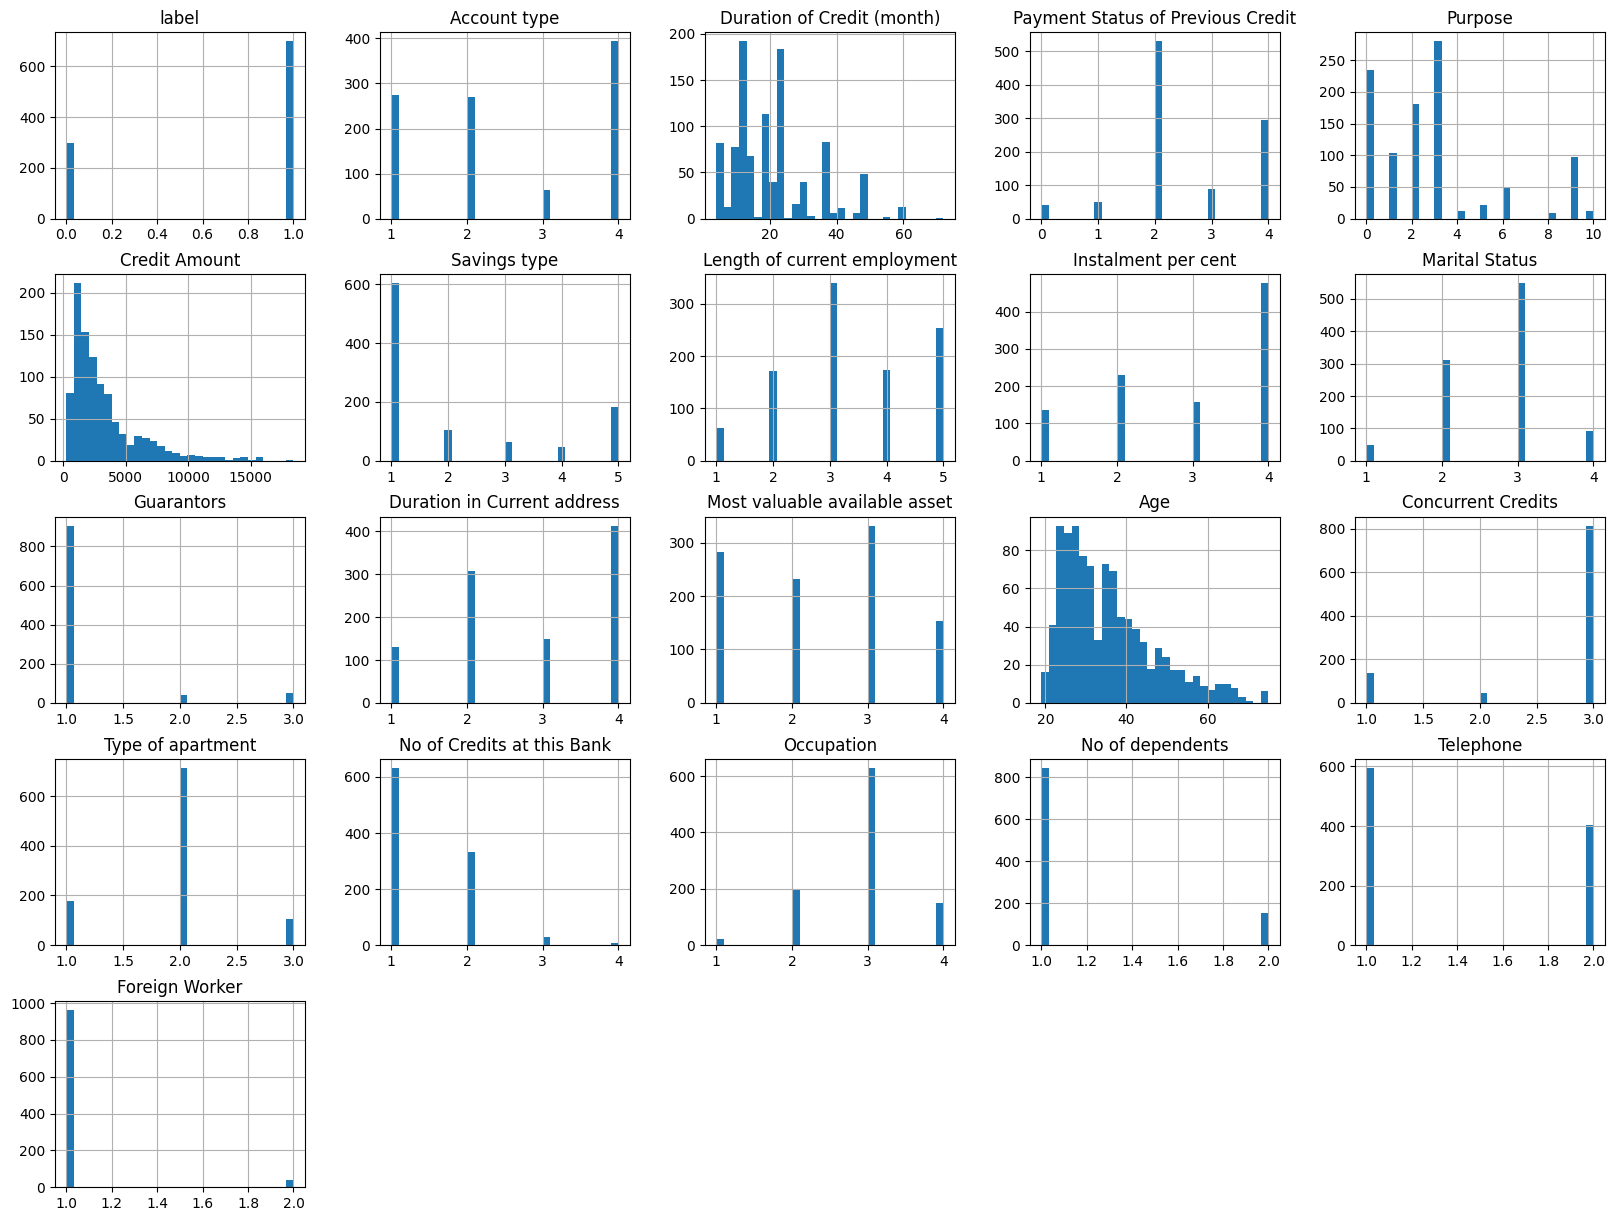

In [292]:
# all the features are numeric
data.hist(bins=30, figsize=(20, 15))
plt.show()

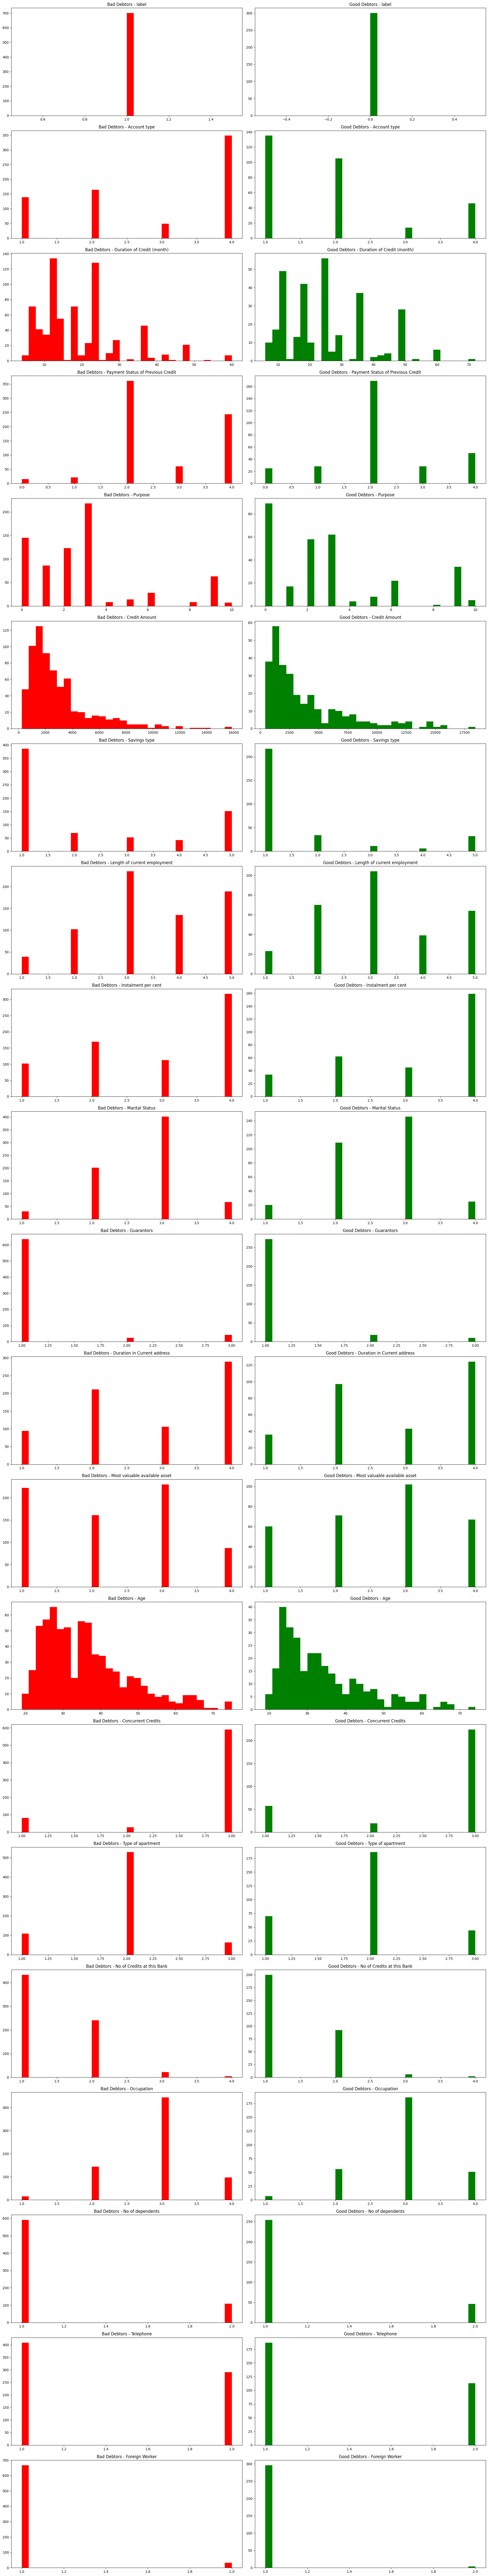

In [293]:
bad_debtors = data[data["label"]==1]
good_debtors = data[data["label"]==0]

columns = data.columns

fig, axes = plt.subplots(len(columns), 2, figsize=(20, 5 * len(columns)))

for i, column in enumerate(columns):
    axes[i, 0].hist(bad_debtors[column], bins=30, color='red')
    axes[i, 0].set_title(f'Bad Debtors - {column}')
    
    axes[i, 1].hist(good_debtors[column], bins=30, color='green')
    axes[i, 1].set_title(f'Good Debtors - {column}')

plt.tight_layout()
plt.show()

The data distribution does not show an obvious difference between the `bad_debtors` and `good_debtors` except for the Account and Savings type.

##### Detecting Outliers and Anomalies (z- score)

In [294]:
def outlier_detection(data):
    columns = data.columns
    new_data = data.copy(deep=True)
    for column in columns:
        z = f'{column}_z-score'
        new_data[z]=(new_data[column] - new_data[column].mean())/new_data[column].std()
        new_data = new_data[(new_data[z] > -3) & (new_data[z] < 3)]
        new_data = new_data.drop(z, axis=1)
        # print(column,len(new_data))
    return new_data

In [295]:
data = outlier_detection(data)


In [296]:
data.head()
len(data)

869

### Identifying Relationships Between Variables

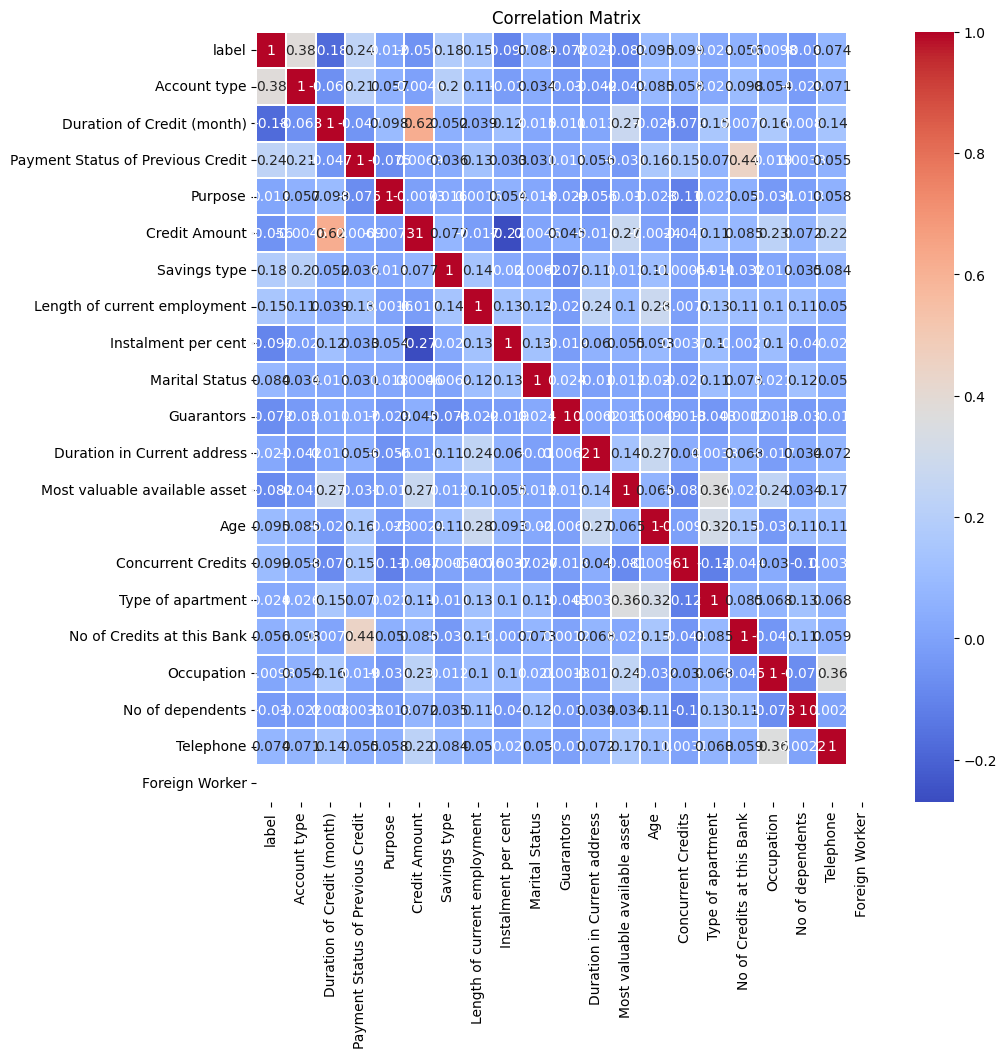

In [297]:
# Correlation
# Calculate the correlation matrix
correlation_matrix = data.corr()

# Display the correlation matrix
# Create a heatmap of the correlation matrix
plt.figure(figsize=(10, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.1)
plt.title('Correlation Matrix')
plt.show()


**Interpretation**

There seems to be a positive relationship between Duration of credit (month) and the Credit amount.However, the relationship is too week. The feature have little to no correlation. 

### Insights into Feature Interactions

We will visualize the relationship between the the feature and the target column.

### Dimensionality Reduction

In [298]:
data["label"].value_counts()

label
1    608
0    261
Name: count, dtype: int64

## Define Helper Functions

In [299]:
def scale(data: pd.DataFrame, scaler: str = "standardization") -> pd.DataFrame:
    """
    Scale the numerical columns of a dataframe using either standardization or min-max scaling (normalization).
    
    Args:
    data: The input dataframe that needs to be transformed. It is required to have a 'label' column.
    scaler: The type of scaling to apply - either 'standardization' or 'minmax'.
    
    Returns:
    pd.DataFrame: The dataframe with scaled numerical columns.
    """
    
    if "label" not in data.columns:
        raise ValueError("The input dataframe must contain a 'label' column.")
    
    scaler_options = {
        "standardization": StandardScaler(),
        "minmax": MinMaxScaler()
    }

    if scaler not in scaler_options:
        raise ValueError("Invalid scaler option. Choose either 'standardization' or 'minmax'.")
    
    selected_scaler = scaler_options[scaler]
    columns_to_scale = data.drop(columns=["label"]).columns
    
    data[columns_to_scale] = selected_scaler.fit_transform(data[columns_to_scale])
    
    return data


def model_build(
    X_train: pd.DataFrame, 
    y_train: pd.DataFrame, 
    algorithm: Union[Type[BaseEstimator], str], 
    algorithm_args: Optional[Dict[str, Any]] = None, 
    random_state: Optional[int] = seed
) -> Union[BaseEstimator, xgb.Booster]:
    """
    Build and train a machine learning model based on the specified algorithm.
    
    Args:
    X_train: Training (features) dataset.
    y_train: Training labels.
    algorithm (Union[Type[BaseEstimator], str]): The algorithm to use for training. 
        Can be a scikit-learn estimator class or 'xgboost'.
    algorithm_args (Optional[Dict[str, Any]]): Arguments to pass to the algorithm, such as hyperparameters.
    random_state (Optional[int]): Random seed for reproducibility.
    
    Returns:
    Union[BaseEstimator, xgb.Booster]: The trained model.
    """
    if algorithm == 'xgboost':
        dtrain = xgb.DMatrix(X_train, label=y_train)
        
        if algorithm_args is None:
            algorithm_args = {}

        algorithm_args['seed'] = random_state
        
        # num_boost_round = algorithm_args.pop('num_boost_round', 100)
        
        model = xgb.train(algorithm_args, dtrain)
    else:
        if algorithm_args is None:
            algorithm_args = {}

        algorithm_args['random_state'] = random_state
        
        model = algorithm(**algorithm_args)
        model.fit(X_train, y_train)
    
    return model

  
def evaluate(model: Any, X_test: pd.DataFrame, y_test: pd.DataFrame, if_xgboost:bool=False) -> None:
    """
    Evaluate a trained model using test data and print evaluation results.
    
    Args:
    model: The trained model to evaluate.
    X_test: Test (features) dataset.
    y_test: Test labels.
    
    Returns:
    None
    """
    if if_xgboost:
        dtest = xgb.DMatrix(X_test, label=y_test)
        y_pred_prob = model.predict(dtest)
        y_pred = [1 if prob > 0.5 else 0 for prob in y_pred_prob]
    else:
        y_pred = model.predict(X_test)
    
    f1 = f1_score(y_test, y_pred)  # Compute F1 score

    print(f'F1 Score: {f1}')
    print('Confusion Matrix:')
    print(confusion_matrix(y_test, y_pred))
    print('Classification Report:')
    print(classification_report(y_test, y_pred))

## Model Development

### Feature Scaling Requirements

In [300]:

# scale the features
scaled_data = scale(data)
# shuffle the dataset
shuffled_df = data.sample(frac=1, random_state=seed)
shuffled_df = shuffled_df.reset_index(drop=True)

In [301]:
# split into train and test for further preprocessing
train, test = train_test_split(shuffled_df, test_size=0.2, random_state=seed)

train["label"].value_counts()

label
1    489
0    206
Name: count, dtype: int64

### Sampling

In [302]:
len_of_smaller_class = 205
len_of_lager_class = int(len_of_smaller_class*1.4)

bad = train[train["label"] == 1][:len_of_lager_class]
good = train[train["label"] == 0][:len_of_smaller_class]

n_train = pd.concat([bad, good])

## shuffle the data
n_train = n_train.sample(frac=1, random_state=seed).reset_index(drop=True)

n_train["label"].value_counts()

label
1    287
0    205
Name: count, dtype: int64

In [303]:
X_train = n_train.drop(columns=['label'])
X_test = test.drop(columns=['label'])
y_train = n_train['label']
y_test = test['label']

In [304]:
# train and evaluate the model
base_model = model_build(X_train, y_train, RandomForestClassifier)
evaluate(base_model, X_test, y_test)

F1 Score: 0.8067226890756303
Confusion Matrix:
[[32 23]
 [23 96]]
Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.58      0.58        55
           1       0.81      0.81      0.81       119

    accuracy                           0.74       174
   macro avg       0.69      0.69      0.69       174
weighted avg       0.74      0.74      0.74       174



The model achieves a balanced performance with an overall F1 Score of 0.69, indicating reasonable precision and recall across both classes, though there is slight room for improvement, especially in recall for the positive class. The accuracy is 71%, reflecting a good level of correct classifications.

### Assessing Feature Importance

In [305]:
# feature importance using random forest classifier
importances = base_model.feature_importances_
features = X_train.columns
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

feature_importance_df = feature_importance_df.reset_index(drop=True)

feature_importance_df

,Feature,Importance
0,Account type,0.127836
1,Credit Amount,0.116617
2,Age,0.106670
3,Duration of Credit (month),0.086103
4,Purpose,0.071770
5,Payment Status of Previous Credit,0.062015
6,Savings type,0.055067
7,Length of current employment,0.052586
8,Most valuable available asset,0.048369
9,Instalment per cent,0.042278


### Model Optimization

The task does not explicitly state what to optimize for, whether to completely mitigate risks (recall), such that it is pardonable to wrongly classify a non-defaulter as a defaulter or to be more customer-centric (precision) and aviod classifying a non-defaulter as a defaulter. 

In this case, the `f1_score` will be the metric considered since it shows a balance between recall and precision.

##### Feature Selection

Select the most optimal number of important features using the `feature_importance_df`, based on the `f1_score` of the minority class (class 0). 

In [306]:
# range of features to try
feature_counts = range(1, 20)
best_f1_score = 0
best_num_features = 0

for n_feature in feature_counts:
    # use the top n features
    features_to_use = feature_importance_df["Feature"][:n_feature]
    filtered_X_train = X_train[features_to_use]
    filtered_X_test = X_test[features_to_use]
    
    # train and evaluate the model
    model = model_build(filtered_X_train, y_train, RandomForestClassifier)
    y_pred = model.predict(filtered_X_test)
    
    # Filter true and predicted labels for class 0
    y_test_class0 = [1 if label == 0 else 0 for label in y_test]
    y_pred_class0 = [1 if label == 0 else 0 for label in y_pred]

    precision, recall, f1, _ = precision_recall_fscore_support(y_test_class0, y_pred_class0, labels=[1], average='binary')
    print(f'{n_feature} generated precision: {precision}, recall: {recall}, f1_score: {f1}')

    print(f'{n_feature} generated f1 of {f1} for class 0 (non-defaulters)')

    if f1 > best_f1_score:
        best_f1_score = f1
        best_num_features = n_feature

print(f'Best F1 Score: {best_f1_score} with {best_num_features} features')

1 generated precision: 0.5675675675675675, recall: 0.38181818181818183, f1_score: 0.45652173913043476
1 generated f1 of 0.45652173913043476 for class 0 (non-defaulters)
2 generated precision: 0.3235294117647059, recall: 0.4, f1_score: 0.35772357723577236
2 generated f1 of 0.35772357723577236 for class 0 (non-defaulters)
3 generated precision: 0.44642857142857145, recall: 0.45454545454545453, f1_score: 0.45045045045045046
3 generated f1 of 0.45045045045045046 for class 0 (non-defaulters)
4 generated precision: 0.52, recall: 0.4727272727272727, f1_score: 0.49523809523809526
4 generated f1 of 0.49523809523809526 for class 0 (non-defaulters)
5 generated precision: 0.5370370370370371, recall: 0.5272727272727272, f1_score: 0.5321100917431193
5 generated f1 of 0.5321100917431193 for class 0 (non-defaulters)
6 generated precision: 0.5344827586206896, recall: 0.5636363636363636, f1_score: 0.5486725663716814
6 generated f1 of 0.5486725663716814 for class 0 (non-defaulters)
7 generated precision:

In [307]:
# range of features to try
feature_counts = range(1, 20)
best_f1_score = 0
best_num_features = 0

for n_feature in feature_counts:
    # use the top n features
    features_to_use = feature_importance_df["Feature"][:n_feature]
    filtered_X_train = X_train[features_to_use]
    filtered_X_test = X_test[features_to_use]
    
    # train and evaluate the model
    model = model_build(filtered_X_train, y_train, RandomForestClassifier)
    y_pred = model.predict(filtered_X_test)
    
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, labels=[1], average='binary')
    print(f'{n_feature} generated precision: {precision}, recall: {recall}, f1_score: {f1}')

    print(f'{n_feature} generated f1 of {f1} for class 0 (non-defaulters)')

    if f1 > best_f1_score:
        best_f1_score = f1
        best_num_features = n_feature

print(f'Best F1 Score: {best_f1_score} with {best_num_features} features')

1 generated precision: 0.7518248175182481, recall: 0.865546218487395, f1_score: 0.8046875
1 generated f1 of 0.8046875 for class 0 (non-defaulters)
2 generated precision: 0.6886792452830188, recall: 0.6134453781512605, f1_score: 0.6488888888888888
2 generated f1 of 0.6488888888888888 for class 0 (non-defaulters)
3 generated precision: 0.7457627118644068, recall: 0.7394957983193278, f1_score: 0.7426160337552743
3 generated f1 of 0.7426160337552743 for class 0 (non-defaulters)
4 generated precision: 0.7661290322580645, recall: 0.7983193277310925, f1_score: 0.7818930041152263
4 generated f1 of 0.7818930041152263 for class 0 (non-defaulters)
5 generated precision: 0.7833333333333333, recall: 0.7899159663865546, f1_score: 0.7866108786610879
5 generated f1 of 0.7866108786610879 for class 0 (non-defaulters)
6 generated precision: 0.7931034482758621, recall: 0.773109243697479, f1_score: 0.7829787234042553
6 generated f1 of 0.7829787234042553 for class 0 (non-defaulters)
7 generated precision: 0

From the analysis, using 13 will generate a more optimal result, with an f1 score of `~0.8312`.

In [308]:
features_to_use = feature_importance_df["Feature"][:best_num_features]
features_to_use

0                          Account type
1                         Credit Amount
2                                   Age
3            Duration of Credit (month)
4                               Purpose
5     Payment Status of Previous Credit
6                          Savings type
7          Length of current employment
8         Most valuable available asset
9                   Instalment per cent
10          Duration in Current address
11                       Marital Status
Name: Feature, dtype: object

In [309]:
filtered_X_train = X_train[features_to_use]
filtered_X_test = X_test[features_to_use]

# train and evaluate the model
optimal_base_model = model_build(filtered_X_train, y_train, RandomForestClassifier)
evaluate(optimal_base_model, filtered_X_test, y_test)

F1 Score: 0.831275720164609
Confusion Matrix:
[[ 32  23]
 [ 18 101]]
Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.58      0.61        55
           1       0.81      0.85      0.83       119

    accuracy                           0.76       174
   macro avg       0.73      0.72      0.72       174
weighted avg       0.76      0.76      0.76       174



**Based on the above analysis, explore other ML algorithms, using the filtered data of 12 features.**

> XGBOOST

In [310]:
xgb_model = model_build(
    X_train=filtered_X_train, 
    y_train=y_train, 
    algorithm='xgboost', 
    algorithm_args={
        'objective': 'binary:logistic',
        'max_depth': 6,
        'eta': 0.1,
        'eval_metric': 'logloss',
        'num_boost_round': 100
    }
)

evaluate(xgb_model, filtered_X_test, y_test, if_xgboost=True)

F1 Score: 0.7627118644067796
Confusion Matrix:
[[28 27]
 [29 90]]
Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.51      0.50        55
           1       0.77      0.76      0.76       119

    accuracy                           0.68       174
   macro avg       0.63      0.63      0.63       174
weighted avg       0.68      0.68      0.68       174



> Support Vector Classifier (SVC)

In [311]:
svc_model = model_build(
    X_train=filtered_X_train, 
    y_train=y_train, 
    algorithm=SVC, 
    algorithm_args={'kernel': 'linear', 'probability': True}
)

evaluate(svc_model, filtered_X_test, y_test)

F1 Score: 0.8368200836820083
Confusion Matrix:
[[ 35  20]
 [ 19 100]]
Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.64      0.64        55
           1       0.83      0.84      0.84       119

    accuracy                           0.78       174
   macro avg       0.74      0.74      0.74       174
weighted avg       0.77      0.78      0.78       174



> ExtraTreeClassifier

In [312]:
ex_trees_model = model_build(
    X_train=filtered_X_train, 
    y_train=y_train, 
    algorithm=ExtraTreesClassifier, 
    algorithm_args={'n_estimators': 100}
)

evaluate(ex_trees_model, filtered_X_test, y_test)

F1 Score: 0.8326530612244898
Confusion Matrix:
[[ 31  24]
 [ 17 102]]
Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.56      0.60        55
           1       0.81      0.86      0.83       119

    accuracy                           0.76       174
   macro avg       0.73      0.71      0.72       174
weighted avg       0.76      0.76      0.76       174



The best model generated with the under sampling approach is Support Vector Classifier (SVC) and with an overall f1 score of `~0.8368`.

### Feature Reduction

Reducing the number of features can help in the expandability of the model. It also allows the business to focus on key features that will have the greatest impact without reducing performance. Given the Feature selection results above, We can get a very high performance with only `9` features.

In [313]:
features_to_use = feature_importance_df["Feature"][:9]
features_to_use

0                         Account type
1                        Credit Amount
2                                  Age
3           Duration of Credit (month)
4                              Purpose
5    Payment Status of Previous Credit
6                         Savings type
7         Length of current employment
8        Most valuable available asset
Name: Feature, dtype: object

In [314]:
filtered_X_train = X_train[features_to_use]
filtered_X_test = X_test[features_to_use]

# train and evaluate the model
optimal_base_model = model_build(filtered_X_train, y_train, RandomForestClassifier)
evaluate(optimal_base_model, filtered_X_test, y_test)

F1 Score: 0.8200836820083682
Confusion Matrix:
[[33 22]
 [21 98]]
Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.60      0.61        55
           1       0.82      0.82      0.82       119

    accuracy                           0.75       174
   macro avg       0.71      0.71      0.71       174
weighted avg       0.75      0.75      0.75       174



> XG Boost

In [315]:
xgb_model = model_build(
    X_train=filtered_X_train, 
    y_train=y_train, 
    algorithm='xgboost', 
    algorithm_args={
        'objective': 'binary:logistic',
        'max_depth': 6,
        'eta': 0.1,
        'eval_metric': 'logloss',
        'num_boost_round': 100
    }
)

evaluate(xgb_model, filtered_X_test, y_test, if_xgboost=True)

F1 Score: 0.7800829875518672
Confusion Matrix:
[[27 28]
 [25 94]]
Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.49      0.50        55
           1       0.77      0.79      0.78       119

    accuracy                           0.70       174
   macro avg       0.64      0.64      0.64       174
weighted avg       0.69      0.70      0.69       174



> Support Vector Classifier (SVC)

In [316]:
svc_model = model_build(
    X_train=filtered_X_train, 
    y_train=y_train, 
    algorithm=SVC, 
    algorithm_args={'kernel': 'linear', 'probability': True}
)

evaluate(svc_model, filtered_X_test, y_test)

F1 Score: 0.8354430379746836
Confusion Matrix:
[[36 19]
 [20 99]]
Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.65      0.65        55
           1       0.84      0.83      0.84       119

    accuracy                           0.78       174
   macro avg       0.74      0.74      0.74       174
weighted avg       0.78      0.78      0.78       174



> ExtraTreeClassifier

In [317]:
ex_trees_model = model_build(
    X_train=filtered_X_train, 
    y_train=y_train, 
    algorithm=ExtraTreesClassifier, 
    algorithm_args={'n_estimators': 100}
)

evaluate(ex_trees_model, filtered_X_test, y_test)

F1 Score: 0.7914893617021277
Confusion Matrix:
[[32 23]
 [26 93]]
Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.58      0.57        55
           1       0.80      0.78      0.79       119

    accuracy                           0.72       174
   macro avg       0.68      0.68      0.68       174
weighted avg       0.72      0.72      0.72       174



In [318]:
optimal_model = svc_model

### Summary

The best model is the one generated from the `Support Vector Classifier (SVC)` after applying undersampling.

### Details of the model:

> Data Used:

- The data has `287` samples that belong to the defaulter class (class 1) and `205` samples belonging to the non-defaulters class (class 0).
- Based on feature importance, only `9` features are used in this model.

> Model Performance:
The model has an f1 score of `0.64` on class 0 and `0.84` on class 1, with an overall f1 score of `0.8354`. 

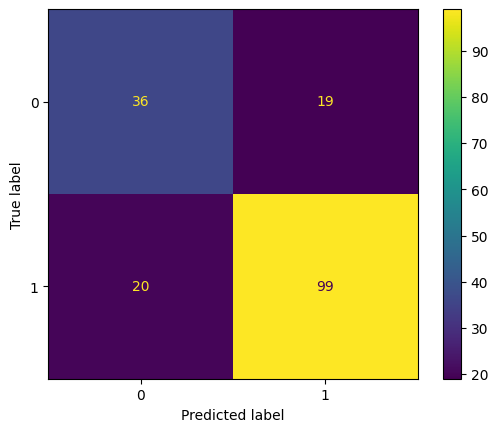

In [319]:
y_pred = optimal_model.predict(filtered_X_test)

conf_matrix = confusion_matrix(y_test, y_pred)

cm_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = [0, 1])

cm_display.plot()
plt.show()

- `36` samples are correctly predicted as non-defaulters out of a total of 55
- `99` samples are correctly predicted as defaulters out of a total of 119.